In [1]:
# Standard library imports
from collections import Counter
import os
import random
import zipfile

# Third-party data science and machine learning imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
from sklearn.model_selection import train_test_split

# DICOM handling
import pydicom

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import (
    Dataset,
    DataLoader,
    Subset
)

# Torchvision imports
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights

In [2]:
if torch.cuda.is_available():
    print(f"GPUs Available: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"- {torch.cuda.get_device_name(i)}")
else:
    print("No GPUs available.")

GPUs Available: 1
- Tesla P100-PCIE-16GB


# Kaggle

In [3]:
# Configuration
DATASET_NAME = 'rsna-mil-training'
JOB_NAME = 'RSNA-ResNet18'
INPUT_DIR = '/kaggle/input'
OUTPUT_DIR = '/kaggle/working'

# Directories
CHECKPOINTS_DIR = os.path.join(OUTPUT_DIR, JOB_NAME, 'checkpoints')
FIGURES_DIR = os.path.join(OUTPUT_DIR, JOB_NAME, 'figures')
DICOM_DIR = os.path.join(INPUT_DIR, DATASET_NAME, DATASET_NAME)

# File Paths
CSV_PATH = f'{DICOM_DIR}/training_1000_scan_subset.csv'

# Image Processing Parameters
MAX_SLICES = 60
HEIGHT = 224
WIDTH = 224

# Training Hyperparameters
BATCH_PATIENTS = 32
NUM_EPOCHS = 15
LEARNING_RATE = 1e-4

# Early stopping
PATIENCE = 3
MIN_DELTA = 1e-2

# Dataset Split Ratios
VAL_SIZE = 0.15
TEST_SIZE = 0.15

# Create Necessary Directories
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

# Load CSV from Kaggle environment (no need to unzip)
medical_scan_data = pd.read_csv(CSV_PATH)

# Random seed
SEED = 42

In [4]:
medical_scan_data.head(1)

,patient_id,study_instance_uid,images,labels,patient_label,length
0,ID_2e010e33,ID_bda0f47e84,"['ID_b9035cb1e.dcm', 'ID_0713bed86.dcm', 'ID_5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,48


In [5]:
medical_scan_data.columns

Index(['patient_id', 'study_instance_uid', 'images', 'labels', 'patient_label',
       'length'],
      dtype='object')

# Data augmentation

In [6]:
class DatasetAugmentor:
    def __init__(self, height, width, n_levels=3, seed=None):
        self.height = height
        self.width = width
        self.seed = seed
        self.n_levels = n_levels
        
        # Store parameters for each level of augmentation
        self.transform_params = [self._create_transform(i) for i in range(1, n_levels + 1)]

    def _sample_value(self, value_range):
        if isinstance(value_range, tuple):
            random.seed(self.seed)
            return random.uniform(value_range[0], value_range[1])
        return value_range

    def _create_transform(self, level):
        degrees = 5 * level  # Increase degrees with level
        translate_range = (0.1 * level, 0.1 * level)
        scale_range = (1 - 0.1 * level, 1 + 0.1 * level)
        brightness_range = (0.1 * level, 0.1 * level)
        contrast_range = (0.1 * level, 0.1 * level)
        blur_sigma_range = (0.1 * level, 0.2 * level)
        apply_elastic = (level > 1)  # Only apply elastic for higher levels

        return self._create_transform_params(degrees, translate_range, scale_range,
                                             brightness_range, contrast_range,
                                             blur_sigma_range, apply_elastic)

    def _create_transform_params(self, degrees, translate_range, scale_range,
                                  brightness_range, contrast_range,
                                  blur_sigma_range, apply_elastic):
        return {
            "degrees": self._sample_value(degrees),
            "translate": (self._sample_value(translate_range), self._sample_value(translate_range)),
            "scale": self._sample_value(scale_range),
            "brightness": self._sample_value(brightness_range),
            "contrast": self._sample_value(contrast_range),
            "blur_sigma": self._sample_value(blur_sigma_range),
            "apply_elastic": apply_elastic
        }

    def apply_transform(self, image, level):        
        if self.seed is not None:
            torch.manual_seed(self.seed)
            random.seed(self.seed)

        if level < 1 or level > self.n_levels:
            raise ValueError(f"Level must be between 1 and {self.n_levels}")
        
        params = self.transform_params[level - 1]
        transform = self._get_transform(params)

        transformed_image = transform(image)        
        return transformed_image

    def _get_transform(self, params):
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=params["degrees"], translate=params["translate"], scale=(params["scale"], params["scale"])),
            transforms.ColorJitter(brightness=params["brightness"], contrast=params["contrast"]),
            transforms.GaussianBlur(kernel_size=(3, 3), sigma=params["blur_sigma"]),
            transforms.RandomApply([transforms.ElasticTransform()] if params["apply_elastic"] else [], p=0.3),
            transforms.Resize(256),
            transforms.CenterCrop(self.height),
            transforms.ToTensor(),
#             transforms.Normalize(mean=[0.16774411, 0.1360026, 0.19076315], std=[0.3101935, 0.27605791, 0.30469988]),
            transforms.RandomApply([self._channel_shuffle], p=0.3)
        ])

    def _channel_shuffle(self, tensor):
        torch.manual_seed(self.seed)
        channels = tensor.shape[0]
        indices = torch.randperm(channels)
        return tensor[indices]

In [7]:
augmentor = DatasetAugmentor(HEIGHT, WIDTH, seed=SEED, n_levels=3)

In [8]:
def split_dataframe(medical_scan_data, val_size=VAL_SIZE, test_size=TEST_SIZE, seed=SEED):
    images, labels, patient_ids, study_instance_uids = [], [], [], []

    for _, row in medical_scan_data.iterrows():
        row_images = row['images'] if isinstance(row['images'], list) else eval(row['images'])
        row_labels = row['labels'] if isinstance(row['labels'], list) else eval(row['labels'])
        patient_id = row['patient_id']
        study_instance_uid = row['study_instance_uid']

        if len(row_images) != len(row_labels):
            print(f'Length mismatch in row; skipping. Images: {len(row_images)}, Labels: {len(row_labels)}')
            continue
        
        images.extend(row_images)
        labels.extend(row_labels)
        patient_ids.extend([patient_id] * len(row_images))
        study_instance_uids.extend([study_instance_uid] * len(row_images))

    if not images or not labels:
        raise ValueError('No valid images or labels found.')

    # Create DataFrame with patient info
    image_data = pd.DataFrame({
        'image': images,
        'label': labels,
        'patient_id': patient_ids,
        'study_instance_uid': study_instance_uids
    })

    # Split into train, validation, and test sets
    train_indices, test_indices = train_test_split(
        image_data.index,
        test_size=test_size,
        stratify=image_data['label'],
        random_state=seed
    )
    
    val_relative_size = val_size / (1 - test_size)
    train_indices, val_indices = train_test_split(
        train_indices,
        test_size=val_relative_size,
        stratify=image_data.loc[train_indices, 'label'],
        random_state=seed
    )

    return (
        image_data.iloc[train_indices].reset_index(drop=True),
        image_data.iloc[val_indices].reset_index(drop=True),
        image_data.iloc[test_indices].reset_index(drop=True)
    )

In [9]:
train_df, val_df, test_df = split_dataframe(medical_scan_data)

In [10]:
train_df.head(1)

,image,label,patient_id,study_instance_uid
0,ID_4d6921c9a.dcm,1,ID_88f26f1c,ID_446e781d4b


In [11]:
print(f'Length of (train valid test) dataframe: {len(train_df), len(val_df), len(test_df)}')

Length of (train valid test) dataframe: (24147, 5175, 5175)


# Kaggle dataset gen.

In [12]:
class MedicalScanDataset(Dataset):
    def __init__(self, dicom_dir, medical_scan_data, height, width, augmentor=None, balance_dataset=False, is_train=False):
        self.dicom_dir = dicom_dir
        self.medical_scan_data = medical_scan_data
        self.height = height
        self.width = width
        self.augmentor = augmentor
        self.dicom_paths, self.all_labels = self._get_dicom_paths_and_labels()
        
        self.image_cache = {}

        if balance_dataset:
            self._balance_dataset()
            
        self.normalize = transforms.Normalize(
            mean=[0.16774411, 0.1360026, 0.19076315],
            std=[0.3101935, 0.27605791, 0.30469988]
        )
        
        self.is_train = is_train

    def __len__(self):
        # Adjust length to account for N levels of augmentation per slice
        return len(self.dicom_paths) * (self.augmentor.n_levels if self.augmentor else 1)

    def __getitem__(self, idx):
        if self.augmentor:
            orig_idx = idx // (self.augmentor.n_levels + 1)
            transform_idx = idx % (self.augmentor.n_levels + 1)
        else:
            orig_idx = idx
            transform_idx = 0

        dicom_file, label = self.dicom_paths[orig_idx], self.all_labels[orig_idx]

        if dicom_file not in self.image_cache:
            images = self._process_dicom_file(dicom_file)
            self.image_cache[dicom_file] = images
        else:
            images = self.image_cache[dicom_file]

        if self.augmentor:
            if transform_idx == 0:
                transformed_img = images
            else:
                transformed_img = self.augmentor.apply_transform(images, transform_idx)
        else:
            transformed_img = images

        # Apply normalization only for training set when augmentor is None
        if self.is_train and self.augmentor is None:
            transformed_img = self.normalize(transformed_img)

        labels = torch.tensor(label, dtype=torch.float32)

        return transformed_img, labels

    def _get_dicom_paths_and_labels(self):
        dicom_paths = []
        labels = []

        for _, row in self.medical_scan_data.iterrows():
            patient_id = row['patient_id'].replace("ID_", "")
            study_instance_uid = row['study_instance_uid'].replace("ID_", "")
            dicom_dir_path = os.path.join(self.dicom_dir, f"{patient_id}_{study_instance_uid}")

            if os.path.exists(dicom_dir_path):
                # Ensure images and labels are lists
                images = row['image'] if isinstance(row['image'], list) else [row['image']]
                label = row['label'] if isinstance(row['label'], list) else [row['label']]

                # Check if lengths match
                if len(images) != len(label):
                    print(f"Length mismatch for patient {patient_id}: {len(images)} images vs {len(label)} labels")
                    continue  # Skip this row if there's a mismatch

                for image, label in zip(images, label):
                    dicom_file_path = os.path.join(dicom_dir_path, image)
                    if os.path.exists(dicom_file_path):
                        dicom_paths.append(dicom_file_path)
                        labels.append(label)
                    else:
                        print(f"DICOM file does not exist: {dicom_file_path}")
            else:
                print(f"DICOM directory does not exist: {dicom_dir_path}")

        return dicom_paths, labels

    def _balance_dataset(self):
        label_counter = Counter(self.all_labels)
        min_class_count = min(label_counter[0], label_counter[1])

        dicom_pairs_0 = [(path, label) for path, label in zip(self.dicom_paths, self.all_labels) if label == 0]
        dicom_pairs_1 = [(path, label) for path, label in zip(self.dicom_paths, self.all_labels) if label == 1]

        random.shuffle(dicom_pairs_0)
        random.shuffle(dicom_pairs_1)

        dicom_pairs_0 = dicom_pairs_0[:min_class_count]
        dicom_pairs_1 = dicom_pairs_1[:min_class_count]

        balanced_pairs = dicom_pairs_0 + dicom_pairs_1
        random.shuffle(balanced_pairs)

        self.dicom_paths, self.all_labels = zip(*balanced_pairs)

    def _process_dicom_file(self, dicom_file):
        dicom = pydicom.dcmread(dicom_file)
        img = self._preprocess_slice(dicom)
        return torch.from_numpy(img).float()

    def _preprocess_slice(self, dicom):
        return self._bsb_window(dicom).astype(np.float16)

    def _bsb_window(self, dcm):
        brain_img = self._window_image(dcm, 40, 80)
        subdural_img = self._window_image(dcm, 80, 200)
        soft_img = self._window_image(dcm, 40, 380)

        brain_img_normalized = (brain_img - 0) / 80
        subdural_img_normalized = (subdural_img - (-20)) / 200
        soft_img_normalized = (soft_img - (-150)) / 380

        return np.stack([brain_img_normalized, subdural_img_normalized, soft_img_normalized], axis=0)

    def _window_image(self, dcm, window_center, window_width):
        img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
        img_min = window_center - window_width // 2
        img_max = window_center + window_width // 2
        img = np.clip(img, img_min, img_max)
        
        # Resize image to specified height and width
        return cv2.resize(img, (self.height, self.width), interpolation=cv2.INTER_LINEAR)

    def calculate_mean_std(self):
        total_mean = np.zeros(3)
        total_var = np.zeros(3)
        total_count = 0
        
        for dicom_file in self.dicom_paths:
            img = self._process_dicom_file(dicom_file)
            img_np = img.numpy()
            
            mean = np.mean(img_np, axis=(1, 2))
            var = np.var(img_np, axis=(1, 2))
            
            # Update totals using Welford's method
            total_count += img_np.shape[1] * img_np.shape[2]
            total_mean += mean * (img_np.shape[1] * img_np.shape[2])
            total_var += var * (img_np.shape[1] * img_np.shape[2]) + (mean**2) * (img_np.shape[1] * img_np.shape[2])
        
        final_mean = total_mean / total_count
        final_var = total_var / total_count - (final_mean**2)
        
        final_std = np.sqrt(final_var)

        return final_mean , final_std 

In [13]:
class TrainMedicalScanDataset(MedicalScanDataset):
    def __init__(self, dicom_dir, train_df, height=HEIGHT, width=WIDTH,
                 augmentor=None, balance_dataset=False):
        
        super().__init__(dicom_dir=dicom_dir,
                         medical_scan_data=train_df,
                         height=height,
                         width=width,
                         augmentor=augmentor,
                         balance_dataset=balance_dataset,
                         is_train=True)  # Set is_train to True for training set

class ValMedicalScanDataset(MedicalScanDataset):
    def __init__(self, dicom_dir, val_df, height=HEIGHT, width=WIDTH,
                 augmentor=None, balance_dataset=False):
        
        super().__init__(dicom_dir=dicom_dir,
                         medical_scan_data=val_df,
                         height=height,
                         width=width,
                         augmentor=augmentor,
                         balance_dataset=balance_dataset,
                         is_train=False)  # Set is_train to False for validation set

class TestMedicalScanDataset(MedicalScanDataset):
    def __init__(self, dicom_dir, test_df, height=HEIGHT, width=WIDTH,
                 augmentor=None, balance_dataset=False):
        
        super().__init__(dicom_dir=dicom_dir,
                         medical_scan_data=test_df,
                         height=height,
                         width=width,
                         augmentor=augmentor,
                         balance_dataset=balance_dataset,
                         is_train=False)  # Set is_train to False for test set

In [14]:
train_dataset = TrainMedicalScanDataset(dicom_dir=DICOM_DIR, train_df=train_df, augmentor=None, balance_dataset=True)
val_dataset = ValMedicalScanDataset(dicom_dir=DICOM_DIR, val_df=val_df, augmentor=None, balance_dataset=True)
test_dataset = TestMedicalScanDataset(dicom_dir=DICOM_DIR, test_df=test_df, augmentor=None, balance_dataset=True)

In [15]:
images, labels = train_dataset[0]
print("Shape of image tensor:", images.shape)
print("Label:", labels)

Shape of image tensor: torch.Size([3, 224, 224])
Label: tensor(1.)


In [16]:
def print_label_distribution(dataset):
    label_counts = Counter(dataset.all_labels)
    total = sum(label_counts.values())
    
    # Derive the name based on the dataset type
    dataset_type = type(dataset).__name__
    print(f'\n{dataset_type} Label Distribution:')
    
    for label, count in label_counts.items():
        percentage = (count / total) * 100
        print(f'Label {label}: {count} ({percentage:.2f}%)')

In [17]:
def plot_original_vs_augmented(dataset):
    if dataset.augmentor is None:
        print("No augmentor provided; cannot plot augmented images.")
        return

    n_levels = dataset.augmentor.n_levels
    n_samples = min(5, len(dataset.dicom_paths))  # Limit samples to 5 or fewer if there are fewer images
    indices = random.sample(range(len(dataset.dicom_paths)), n_samples)

    fig, axs = plt.subplots(n_samples, n_levels + 1, figsize=(15, n_samples * 3))

    for row_idx, orig_idx in enumerate(indices):
        for level in range(n_levels + 1):
            # Calculate dataset index for original and augmented images
            image_idx = orig_idx * (n_levels + 1) + level
            transformed_image, _ = dataset[image_idx]

            # Display the original image in the first column, augmented in subsequent columns
            axs[row_idx, level].imshow(transformed_image.permute(1, 2, 0).numpy(), cmap="gray")
            title = "Original" if level == 0 else f"Augmented Level {level}"
            axs[row_idx, level].set_title(title)
            axs[row_idx, level].axis("off")

    plt.tight_layout()
    plt.show()


In [18]:
# Assuming train_dataset is defined and has an augmentor attached
print_label_distribution(train_dataset)

# Plot original vs augmented images
plot_original_vs_augmented(train_dataset)


TrainMedicalScanDataset Label Distribution:
Label 1: 4262 (50.00%)
Label 0: 4262 (50.00%)
No augmentor provided; cannot plot augmented images.


# Dataloader

In [19]:
class DataloaderManager:
    def __init__(self, train_dataset, val_dataset, test_dataset, batch_size=32, num_workers=4):
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset
        self.batch_size = batch_size
        self.num_workers = num_workers
        
        # Create data loaders
        self.train_loader = self._create_dataloader(self.train_dataset, shuffle=True)
        self.validate_loader = self._create_dataloader(self.val_dataset, shuffle=False)  # Validation typically does not shuffle
        self.test_loader = self._create_dataloader(self.test_dataset, shuffle=False)  # Test typically does not shuffle

    def _create_dataloader(self, dataset, shuffle=True):
        return DataLoader(
            dataset,
            batch_size=self.batch_size,
            shuffle=shuffle,
            num_workers=self.num_workers,
            pin_memory=True
        )

In [20]:
dataloader_manager = DataloaderManager(train_dataset=train_dataset,
                                       val_dataset=val_dataset,
                                       test_dataset=test_dataset,
                                       batch_size=BATCH_PATIENTS,
                                       num_workers=4)

# Model configurations

In [21]:
# 2. Model Definition
class ResNet18(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNet18, self).__init__()
        self.resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        return self.dropout(self.resnet(x))
    
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18().to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s] 


In [22]:
# 3. Loss and Optimizer
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2)

# mode: Monitors 'min' or 'max' changes in metrics.
# factor: The multiplicative factor for reducing the learning rate. 
##  If the current learning rate is 0.01 and factor=0.5, the new learning rate will be 0.01 * 0.5 = 0.005
# patience: Number of epochs to wait for improvement before reducing the learning rate.

In [23]:
def train(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (image, label) in enumerate(train_loader):
        image, label = image.to(device), label.to(device)

        # Forward pass
        optimizer.zero_grad()
        output = model(image).squeeze()
        label = label.reshape(-1)
        
        loss = criterion(output, label)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track loss
        running_loss += loss.item()

        # Calculate accuracy
        predicted_label = (output > 0.5).float()
        total += label.size(0)
        correct += (predicted_label == label).sum().item()

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total

    print(f'Epoch {epoch+1}: Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}%')

    scheduler.step(epoch_loss)
    return epoch_loss

In [24]:
def validate(model, validate_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.inference_mode():
        for batch_idx, (image, label) in enumerate(validate_loader):
            image, label = image.to(device), label.to(device)
            
            # Forward pass
            output = model(image).squeeze()
            label = label.reshape(-1)
            
            loss = criterion(output, label)
            running_loss += loss.item()
            
            # Calculate accuracy
            predicted_label = (output > 0.5).float()
            total += label.size(0)
            correct += (predicted_label == label).sum().item()
    
    # Calculate average loss and accuracy for validation
    val_loss = running_loss / len(validate_loader)
    accuracy = 100 * correct / total
    
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}%')
    
    return val_loss

In [25]:
def save_checkpoint(model, optimizer, scheduler, epoch, loss):
    checkpoint_path = os.path.join(CHECKPOINTS_DIR, f'checkpoint_epoch_{epoch+1}.pth')    
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss
    }, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

In [26]:
def load_best_checkpoint(model, optimizer, scheduler, checkpoint_dir):
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_epoch_') and f.endswith('.pth')]
    if not checkpoint_files:
        print("No checkpoints found.")
        return None, None

    best_checkpoint = min(checkpoint_files, key=lambda x: float(x.split('_')[-1].split('.')[0]))
    checkpoint_path = os.path.join(checkpoint_dir, best_checkpoint)
    
    try:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device(device), weights_only=True)
    except RuntimeError as e:
        print(f"Error loading checkpoint: {e}")
        print(f"Checkpoint file: {checkpoint_path}")
        print(f"File size: {os.path.getsize(checkpoint_path)} bytes")
        return None, None

    try:
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        epoch = checkpoint['epoch']
        best_val_loss = checkpoint['loss']
        
        print(f"Loaded checkpoint from epoch {epoch+1} with validation loss {best_val_loss}")
        
        return epoch, best_val_loss
    except KeyError as e:
        print(f"Error: Checkpoint file is missing expected data: {e}")
        print(f"Available keys in checkpoint: {checkpoint.keys()}")
        return None, None

In [27]:
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(os.path.join(FIGURES_DIR, 'roc_curve.png'))
    plt.show()
    plt.close()

In [28]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.savefig(os.path.join(FIGURES_DIR, 'confusion_matrix.png'))
    plt.show()
    plt.close()

In [29]:
def save_final_model(model, optimizer, scheduler, final_model_path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, final_model_path)
    print(f"Final model saved to {final_model_path}")

In [30]:
def evaluate(model, test_loader, device, criterion):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_scores = []
    test_loss = 0

    with torch.inference_mode():
        for image, label in test_loader:
            image, label = image.to(device), label.to(device)
            
            output = model(image).squeeze()
            label = label.reshape(-1)
            
            loss = criterion(output, label)
            test_loss += loss.item()
            
            predicted_label = (output > 0.5).float()
            total += label.size(0)
            correct += (predicted_label == label).sum().item()
            
            all_labels.extend(label.cpu().numpy())
            all_predictions.extend(predicted_label.cpu().numpy())
            all_scores.extend(output.cpu().numpy())

    accuracy = 100 * correct / total
    avg_loss = test_loss / len(test_loader)
    print(f'Test Accuracy: {accuracy:.4f}%')
    print(f'Test Loss: {avg_loss:.4f}')
    
    plot_roc_curve(np.array(all_labels), np.array(all_scores))
    plot_confusion_matrix(np.array(all_labels), np.array(all_predictions))

    return accuracy, avg_loss

# Main

## Early stopping

In [31]:
class EarlyStopping:
    def __init__(self, patience=PATIENCE, min_delta=MIN_DELTA):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >= self.patience:
            self.early_stop = True

## Train result

In [32]:
loaded_epoch, loaded_best_val_loss = load_best_checkpoint(model, optimizer, scheduler, CHECKPOINTS_DIR)

if loaded_epoch is not None:
    start_epoch = loaded_epoch + 1
    best_val_loss = loaded_best_val_loss
else:
    start_epoch = 0
    best_val_loss = float('inf')

early_stopping = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA)
    
for epoch in range(start_epoch, NUM_EPOCHS):
    train_loader = dataloader_manager.train_loader
    validate_loader = dataloader_manager.validate_loader 
    
    train_loss = train(model, train_loader, criterion, optimizer, scheduler, device)
    val_loss = validate(model, validate_loader, criterion, device)
    
    early_stopping(val_loss)
    
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break
    
    if val_loss < best_val_loss:
        save_checkpoint(model, optimizer, scheduler, epoch, val_loss)
        best_val_loss = val_loss

No checkpoints found.
Epoch 1: Loss: 0.5077, Accuracy: 69.4510%
Validation Loss: 0.5846, Validation Accuracy: 73.4136%
Checkpoint saved: /kaggle/working/RSNA-ResNet18/checkpoints/checkpoint_epoch_1.pth
Epoch 2: Loss: 0.4264, Accuracy: 74.6832%
Validation Loss: 0.5777, Validation Accuracy: 74.1247%
Checkpoint saved: /kaggle/working/RSNA-ResNet18/checkpoints/checkpoint_epoch_2.pth
Epoch 3: Loss: 0.3718, Accuracy: 78.3904%
Validation Loss: 0.6370, Validation Accuracy: 71.4442%
Epoch 4: Loss: 0.3333, Accuracy: 79.9390%
Validation Loss: 0.5191, Validation Accuracy: 77.1335%
Early stopping triggered at epoch 4


## Evaluate result

Test Accuracy: 74.6988%
Test Loss: 0.5430


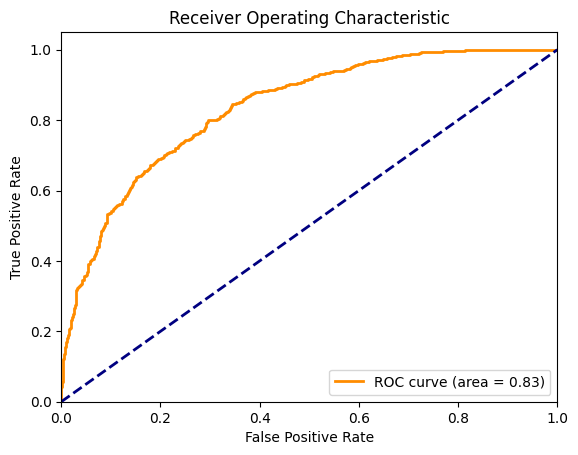

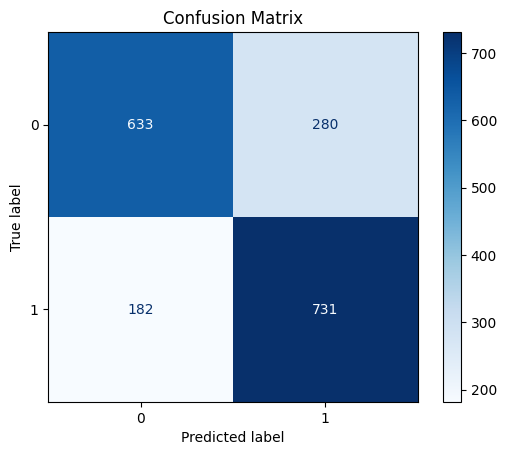

Final model saved to /kaggle/working/RSNA-ResNet18/checkpoints/final_model.pth


In [33]:
test_loader = dataloader_manager.test_loader
accuracy, test_loss = evaluate(model, test_loader, device, criterion)

final_model_path = os.path.join(CHECKPOINTS_DIR, 'final_model.pth')
save_final_model(model, optimizer, scheduler, final_model_path)